In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.config import config
import matplotlib.pyplot as plt

from rodeo.jax.ibm_init import ibm_init
from rodeo.jax.ode_solve import *
from euler_solve import euler
config.update("jax_enable_x64", True)

In [2]:
def hes1(X_t, t, theta):
    "Hes1 model on the log-scale"
    P, M, H = jnp.exp(X_t[:, 0])
    a, b, c, d, e, f, g = theta
    
    x1 = -a*H + b*M/P - c
    x2 = -d + e/(1+P*P)/M
    x3 = -a*P + f/(1+P*P)/H - g
    return jnp.array([[x1], [x2], [x3]])

def hes1_rax(t, y, theta):
    P, M, H = jnp.exp(y)
    a, b, c, d, e, f, g = theta
    
    x1 = -a*H + b*M/P - c
    x2 = -d + e/(1+P*P)/M
    x3 = -a*P + f/(1+P*P)/H - g
    return jnp.array([x1, x2, x3])

def hes1_odeint(X_t, t, theta):
    P, M, H = jnp.exp(X_t)
    a, b, c, d, e, f, g = theta
    x1 = -a*H + b*M/P - c
    x2 = -d + e/(1+P*P)/M
    x3 = -a*P + f/(1+P*P)/H - g
    return jnp.array([x1, x2, x3])


In [16]:
# problem setup and intialization
n_deriv = 1  # Total state
n_obs = 3  # Total measures
n_deriv_prior = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 2000
tmin = 0.
tmax = 240.
theta = jnp.array([0.022, 0.3, 0.031, 0.028, 0.5, 20, 0.3])

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = 0.001
sigma = jnp.array([sigma]*n_obs)

# Initial value, x0, for the IVP
W_mat = np.zeros((n_obs, 1, n_deriv_prior))
W_mat[:, :, 1] = 1
W_block = jnp.array(W_mat)

# Initial x0 for odeint
ode0 = np.log(np.array([1.439, 2.037, 17.904]))

# Initial x0 for jax block
x0 = jnp.log(jnp.array([[1.439], [2.037], [17.904]]))
v0 = hes1(x0, 0, theta)
X0 = jnp.concatenate([x0, v0],axis=1)
pad_dim = n_deriv_prior - n_deriv - 1
x0_block = jnp.pad(X0, [(0, 0), (0, pad_dim)])


# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
n_order = jnp.array([n_deriv_prior]*n_obs)
ode_init = ibm_init(dt, n_order, sigma)

key = jax.random.PRNGKey(0)
sim_jit = jax.jit(solve_mv, static_argnums=(1, 6))
sim1 = sim_jit(key=key, fun=hes1,
        x0=x0_block, theta=theta,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **ode_init)[0]

In [17]:
from scipy.integrate import odeint
import numpy as np
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(hes1_odeint, ode0, tseq, args=(theta,))


In [4]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
term = ODETerm(hes1_rax)
solver = Dopri5()
saveat = SaveAt(ts=tseq)
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
sol = diffeqsolve(term, solver, args = theta, t0=tmin, t1=tmax, dt0=dt, y0=jnp.array(ode0), saveat=saveat,
                  stepsize_controller=stepsize_controller)

NameError: name 'tseq' is not defined

In [18]:
euler_sim = euler(hes1_odeint, ode0, theta, tmin, tmax, n_eval)

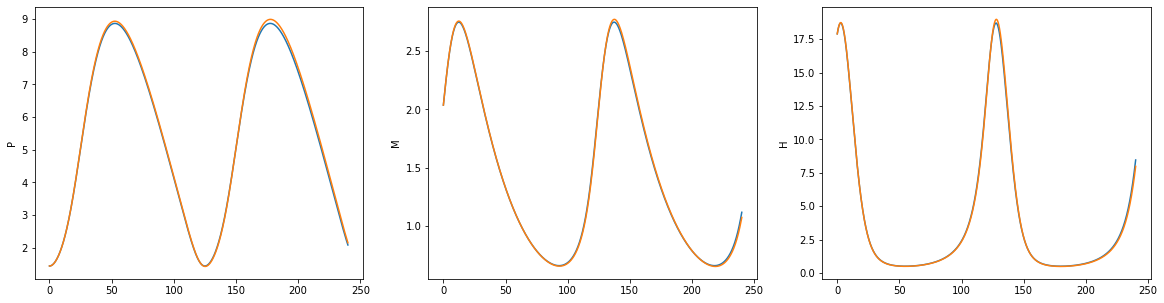

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ylabel = ["P", "M", "H"]
for i in range(3):
    
    #axs[i].plot(tseq, jnp.exp(sim1[:, i, 0]), label = 'Kalman')
    axs[i].plot(tseq, jnp.exp(exact[:, i]), label = 'odeint')
    #axs[i].plot(tseq, jnp.exp(sol.ys[:, i]), label = 'diffrax')
    axs[i].plot(tseq, jnp.exp(euler_sim[:, i]), label= 'euler')
    axs[i].set_ylabel(ylabel[i])
    

In [21]:
def ode_fun_jax(X_t, t, theta):
    "FitzHugh-Nagumo ODE."
    a, b, c = theta
    V, R = X_t[:,0]
    return jnp.array([[c*(V - V*V*V/3 + R)],
                    [-1/c*(V - a + b*R)]])


In [31]:
# problem setup and intialization
n_deriv = 1  # Total state
n_obs = 2  # Total measures
n_deriv_prior = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 400
tmin = 0.
tmax = 40.
theta = np.array([0.2, 0.2, 3])
thetaj = jnp.array(theta)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = 0.0001
sigma = jnp.array([sigma]*n_obs)

# Initial value, x0, for the IVP
W_mat = np.zeros((n_obs, 1, n_deriv_prior))
W_mat[:, :, 1] = 1
W_block = jnp.array(W_mat)

# Initial x0 for odeint
ode0 = np.array([-1., 1.])

# Initial x0 for jax block
#x0_block = jnp.array([[-1., 1., 1.], [1., 1/3, -0.3555555555555555]])
x0_block = jnp.array([[-1., 1., 0.], [1., 1/3, 0.]])


# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
n_order = jnp.array([n_deriv_prior]*n_obs)
ode_init = ibm_init(dt, n_order, sigma)

key = jax.random.PRNGKey(0)
sim_jit = jax.jit(solve_sim, static_argnums=(1, 6))
sim1 = sim_jit(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=thetaj,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **ode_init)

In [34]:
def fitz0(X_t, t, theta):
    a, b, c = theta
    V, R = X_t
    return jnp.array([c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)])

In [44]:
n_eval = 4000
euler_sim = euler(fitz0, ode0, theta, tmin, tmax, n_eval)

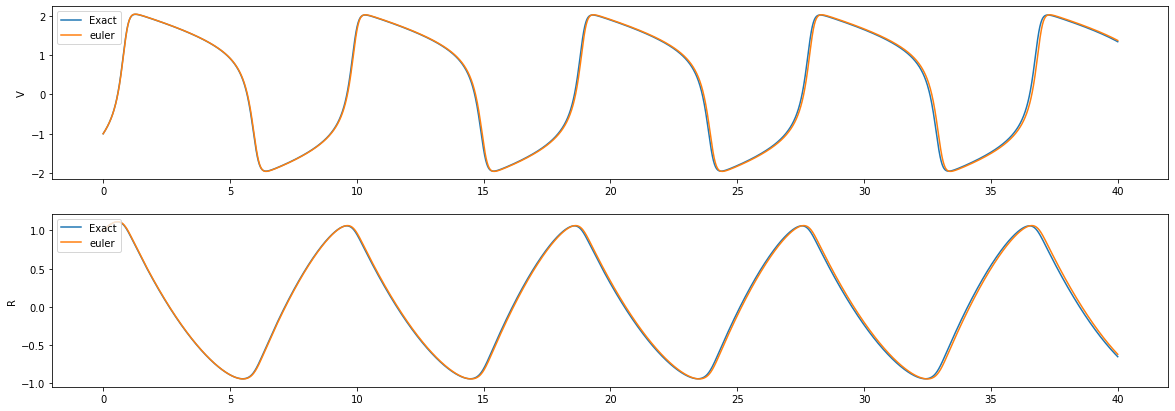

In [45]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(fitz0, ode0, tseq, args=(theta,))
_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ["V", "R"]
for i in range(n_obs):
    #axs[i].plot(tseq,sim1[:,i, 0], label="Kalman")
    #axs[i].plot(tseq, knum_sim[:, n_deriv_prior[0]*i], label="Kalman2")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].plot(tseq, euler_sim[:, i], label='euler')
    axs[i].legend(loc='upper left')

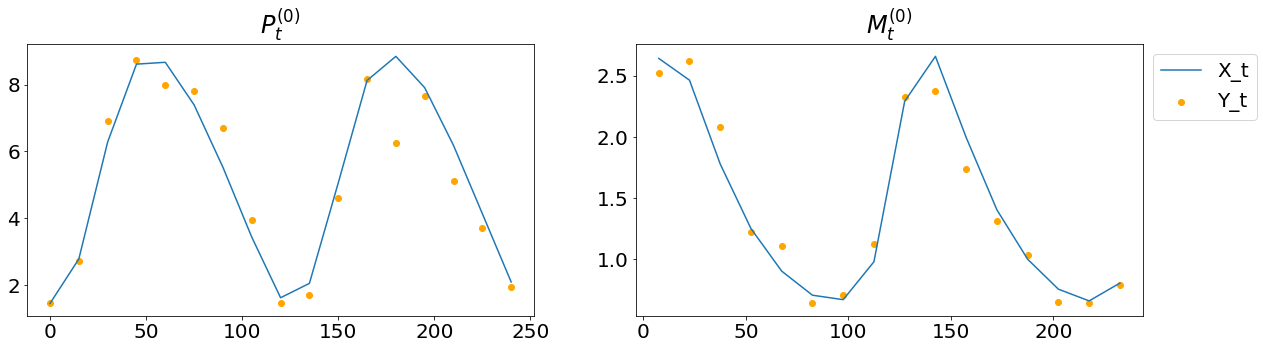

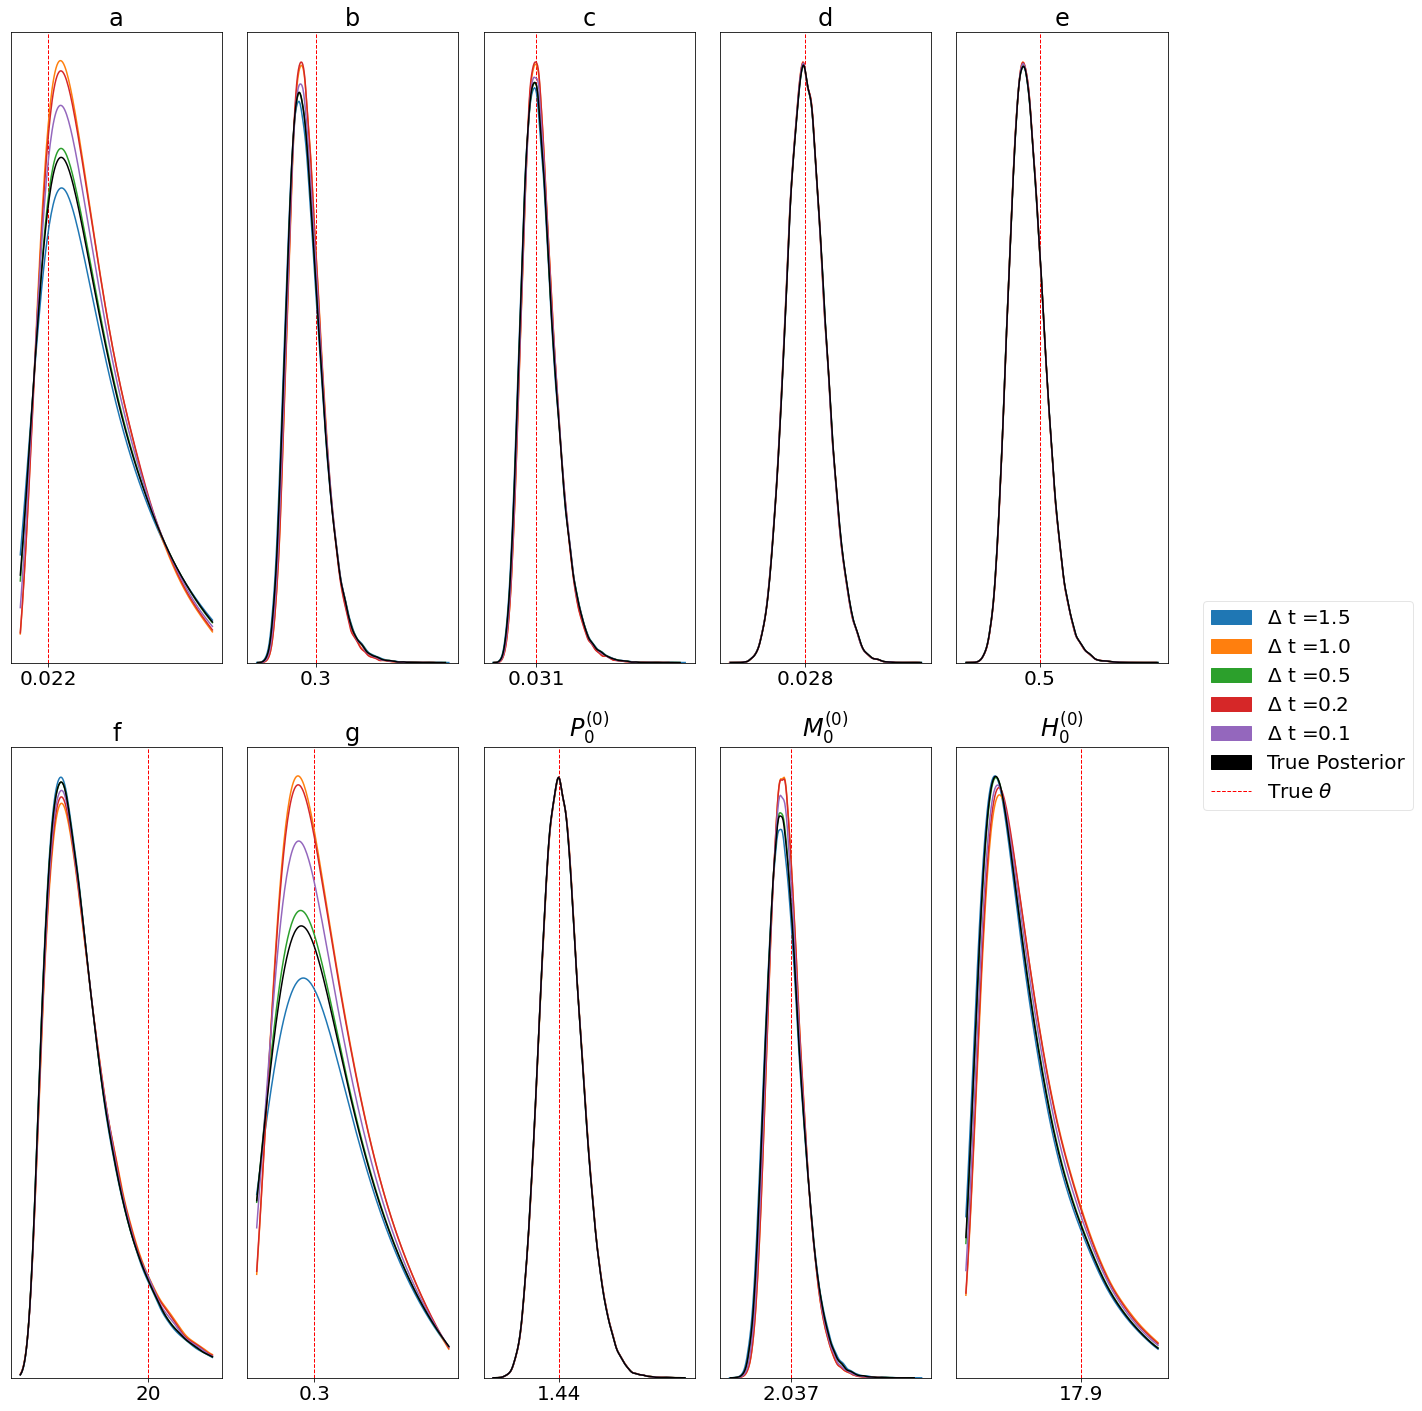

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.config import config

from inference.hes1inf import hes1inf as inference
from rodeo.jax.ibm_init import ibm_init
from rodeo.jax.ode_solve import *
config.update("jax_enable_x64", True)

def hes1(X_t, t, theta):
    "Hes1 model on the log-scale"
    P, M, H = jnp.exp(X_t[:, 0])
    a, b, c, d, e, f, g = theta
    
    x1 = -a*H + b*M/P - c
    x2 = -d + e/(1+P*P)/M
    x3 = -a*P + f/(1+P*P)/H - g
    return jnp.array([[x1], [x2], [x3]])

def hes1pad(X_t, t, theta):
    P, M, H = jnp.exp(X_t)
    a, b, c, d, e, f, g = theta
    x1 = -a*H + b*M/P - c
    x2 = -d + e/(1+P*P)/M
    x3 = -a*P + f/(1+P*P)/H - g
    return jnp.array([[X_t[0], x1, 0],
                      [X_t[1], x2, 0],
                      [X_t[2], x3, 0]])


def hes1_example(load_calcs=False):
    "Perform parameter inference using the Hes1 function."
    # problem setup and intialization
    n_deriv = 1 # number of derivatives in IVP
    n_obs = 3 # number of observations
    n_deriv_prior =  3 # number of derivatives in IBM prior

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    tmin = 0.
    tmax = 240.

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    sigma = jnp.array([.001]*n_obs)
    n_order = jnp.array([n_deriv_prior]*n_obs)

    # Initial x0 for odeint
    x0 = np.log(np.array([1.439, 2.037, 17.904]))

    # pad the inputs
    W_mat = np.zeros((n_obs, 1, n_deriv_prior))
    W_mat[:, :, 1] = 1
    W = jnp.array(W_mat)

    # logprior parameters
    theta_true = np.array([0.022, 0.3, 0.031, 0.028, 0.5, 20, 0.3]) # True theta
    n_theta = len(theta_true)
    phi_mean = np.zeros(n_theta)
    phi_sd = np.log(10)*np.ones(n_theta) 

    # Observation noise
    gamma = 0.15

    # Number of samples to draw from posterior
    n_samples = 100000

    # Initialize inference class and simulate observed data
    key = jax.random.PRNGKey(0)
    inf = inference(key, tmin, tmax, hes1)
    inf.funpad = hes1pad
    tseq = np.linspace(tmin, tmax, 33)
    Y_t, X_t = inf.simulate(x0, theta_true, gamma, tseq)
    
    # exp observations for plot
    Y_exp = np.exp(Y_t) 
    X_exp = np.exp(X_t)

    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(tseq[::2], X_exp[:17], label = 'X_t')
    axs[0].scatter(tseq[::2], Y_exp[:17], label = 'Y_t', color='orange')
    axs[0].set_title("$P^{(0)}_t$")
    axs[1].plot(tseq[1::2], X_exp[17:], label = 'X_t')
    axs[1].scatter(tseq[1::2], Y_exp[17:], label = 'Y_t', color='orange')
    axs[1].set_title("$M^{(0)}_t$")
    axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])
    #fig.savefig('figures/hes1sim.pdf')
    
    dtlst = np.array([1.5, 1, 0.5, 0.2, 0.1])
    obs_t = 7.5
    if load_calcs:
        #theta_euler = np.load('saves/hes1_theta_euler.npy')
        theta_kalman = np.load('saves/hes1_theta_kalman.npy')
        theta_diffrax = np.load('saves/hes1_theta_diffrax.npy')
    else:
        # Parameter inference using Euler's approximation
        theta_euler = np.zeros((len(dtlst), n_samples, n_theta+3))
        phi_init = jnp.append(np.log(theta_true), x0)
#         for i in range(len(dtlst)):
#             print(i)
#             phi_hat, phi_var = inf.phi_fit(Y_t, np.array([None, None, None]), dtlst[i], obs_t, phi_mean, phi_sd, inf.euler_nlpost,
#                                            inf.euler_solve, inf.loglike, gamma, phi_init=phi_init)
#             theta_euler[i] = inf.phi_sample(phi_hat, phi_var, n_samples)
#             theta_euler[i] = np.exp(theta_euler[i])
            
#         np.save('saves/hes1_theta_euler.npy', theta_euler)
#         theta_euler = np.load('saves/hes1_theta_euler.npy')
        
        # Parameter inference using Kalman solver
        theta_kalman = np.zeros((len(dtlst), n_samples, n_theta+3))
        for i in range(len(dtlst)):
            print(i)
            kinit = ibm_init(dtlst[i], n_order, sigma)
            n_eval = int((tmax-tmin)/dtlst[i])
            inf.n_eval = n_eval
            inf.kinit = kinit
            inf.W = W
            phi_hat, phi_var = inf.phi_fit(Y_t, np.array([None, None, None]), dtlst[i], obs_t, phi_mean, phi_sd, inf.kalman_nlpost,
                                           inf.kalman_solve, inf.loglike, gamma, phi_init = phi_init)
            theta_kalman[i] = inf.phi_sample(phi_hat, phi_var, n_samples)
            theta_kalman[i] = np.exp(theta_kalman[i])
        np.save('saves/hes1_theta_kalman2.npy', theta_kalman)
    
        phi_hat, phi_var = inf.phi_fit(Y_t, np.array([None, None, None]), dtlst[0], obs_t, phi_mean, phi_sd, inf.diffrax_nlpost,
                                      inf.diffrax_solve, inf.loglike, gamma, phi_init = phi_init)
        theta_diffrax = inf.phi_sample(phi_hat, phi_var, n_samples)
        theta_diffrax = np.exp(theta_diffrax)
        np.save('saves/hes1_theta_diffrax.npy', theta_diffrax)
    # Produces the graph in Figure 3
    plt.rcParams.update({'font.size': 20})
    var_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', r"$P_0^{(0)}$", r"$M_0^{(0)}$", r"$H_0^{(0)}$"]
    clip = [(0.00, 0.15), None, None, None, None, (0, 30), (0, 1), None, None, (0,30)]
    param_true = np.append(theta_true, np.exp(x0))
    figure = inf.theta_plotsingle(theta_kalman, theta_diffrax, param_true, dtlst, var_names, clip=clip, rows=2)
    figure.savefig('figures/hes1figure.pdf')
    plt.show()
    return

if __name__ == '__main__':
    hes1_example(True)
    

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.config import config

from inference.hes1inf import hes1inf as inference
from rodeo.jax.ibm_init import ibm_init
from rodeo.jax.ode_solve import *
config.update("jax_enable_x64", True)

def hes1(X_t, t, theta):
    "Hes1 model on the log-scale"
    P, M, H = jnp.exp(X_t[:, 0])
    a, b, c, d, e, f, g = theta
    
    x1 = -a*H + b*M/P - c
    x2 = -d + e/(1+P*P)/M
    x3 = -a*P + f/(1+P*P)/H - g
    return jnp.array([[x1], [x2], [x3]])

def hes1pad(X_t, t, theta):
    P, M, H = jnp.exp(X_t)
    a, b, c, d, e, f, g = theta
    x1 = -a*H + b*M/P - c
    x2 = -d + e/(1+P*P)/M
    x3 = -a*P + f/(1+P*P)/H - g
    return jnp.array([[X_t[0], x1, 0],
                      [X_t[1], x2, 0],
                      [X_t[2], x3, 0]])



"Perform parameter inference using the Hes1 function."
# problem setup and intialization
n_deriv = 1 # number of derivatives in IVP
n_obs = 3 # number of observations
n_deriv_prior =  3 # number of derivatives in IBM prior

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0.
tmax = 240.

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = jnp.array([.001]*n_obs)
n_order = jnp.array([n_deriv_prior]*n_obs)

# Initial x0 for odeint
x0 = np.log(np.array([1.439, 2.037, 17.904]))

# pad the inputs
W_mat = np.zeros((n_obs, 1, n_deriv_prior))
W_mat[:, :, 1] = 1
W = jnp.array(W_mat)

# logprior parameters
theta_true = np.array([0.022, 0.3, 0.031, 0.028, 0.5, 20, 0.3]) # True theta
n_theta = len(theta_true)
phi_mean = np.zeros(n_theta)
phi_sd = np.log(10)*np.ones(n_theta) 

# Observation noise
gamma = 0.15

# Number of samples to draw from posterior
n_samples = 100000

# Initialize inference class and simulate observed data
key = jax.random.PRNGKey(0)
inf = inference(key, tmin, tmax, hes1)
inf.funpad = hes1pad
tseq = np.linspace(tmin, tmax, 33)
Y_t, X_t = inf.simulate(x0, theta_true, gamma, tseq)
    
 
    
dtlst = np.array([1.5, 1, 0.5, 0.2, 0.1])
obs_t = 7.5

kinit = ibm_init(dtlst[0], n_order, sigma)
n_eval = int((tmax-tmin)/dtlst[0])
inf.n_eval = n_eval
inf.kinit = kinit
inf.W = W
phi_init = jnp.append(np.log(theta_true), x0)
phi_hat, phi_var = inf.phi_fit(Y_t, np.array([None, None, None]), dtlst[0], obs_t, phi_mean, phi_sd, inf.diffrax_nlpost,
                              inf.diffrax_solve, inf.loglike, gamma, phi_init = phi_init)

theta_diffrax = inf.phi_sample(phi_hat, phi_var, n_samples)
theta_diffrax = np.exp(theta_diffrax)
np.save('saves/hes1_theta_diffrax.npy', theta_diffrax)
# # Produces the graph in Figure 3
# plt.rcParams.update({'font.size': 20})
# var_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', "P", "M", "H"]
# clip = [(0.00, 0.15), None, None, None, None, (0, 30), (0, 1), None, None, (0,30)]
# param_true = np.append(theta_true, np.exp(x0))
#figure = inf.theta_plotsingle(theta_kalman, theta_diffrax, param_true, dtlst, var_names, clip=clip, rows=2)
#figure.savefig('figures/hes1figure.pdf')

    

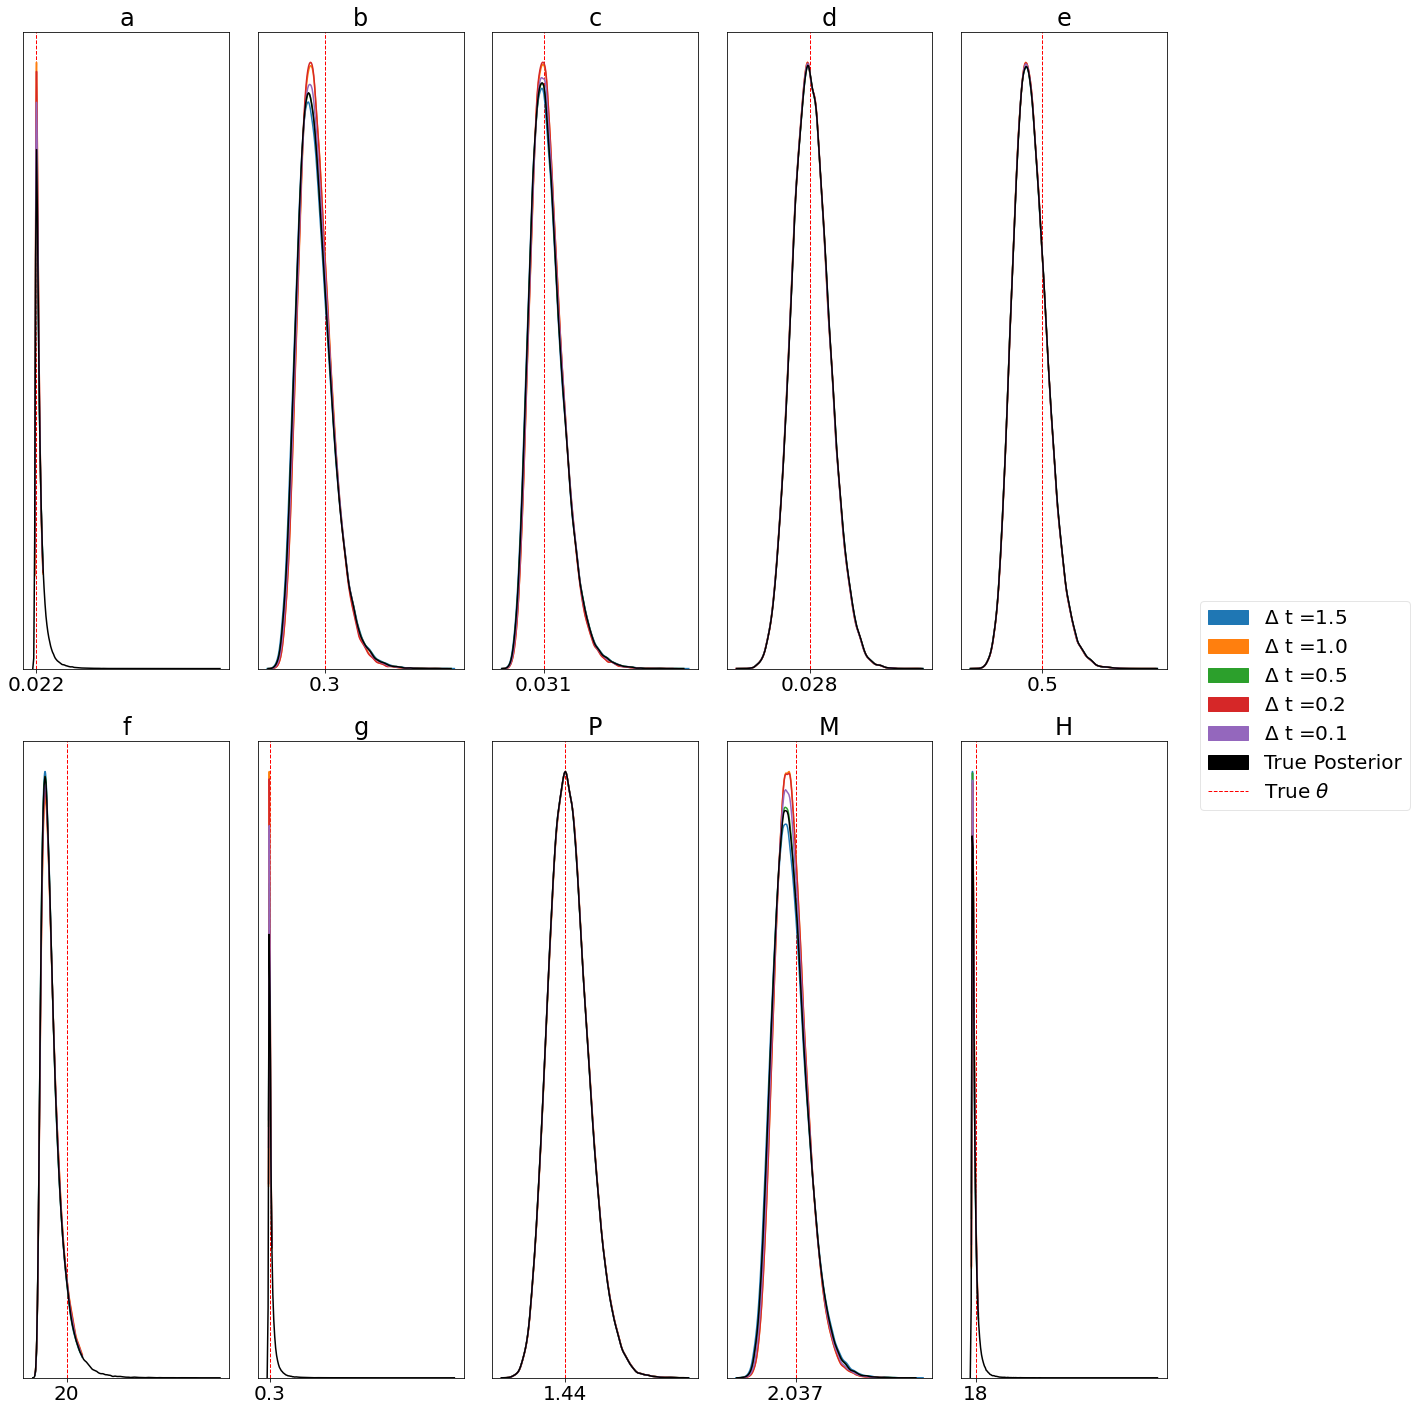

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.config import config

from inference.hes1inf import hes1inf as inference
from rodeo.jax.ibm_init import ibm_init
from rodeo.jax.ode_solve import *
config.update("jax_enable_x64", True)

def hes1(X_t, t, theta):
    "Hes1 model on the log-scale"
    P, M, H = jnp.exp(X_t[:, 0])
    a, b, c, d, e, f, g = theta
    
    x1 = -a*H + b*M/P - c
    x2 = -d + e/(1+P*P)/M
    x3 = -a*P + f/(1+P*P)/H - g
    return jnp.array([[x1], [x2], [x3]])

# Initial x0 for odeint
x0 = np.log(np.array([1.439, 2.037, 17.904]))


# logprior parameters
theta_true = np.array([0.022, 0.3, 0.031, 0.028, 0.5, 20, 0.3]) # True theta

dtlst = np.array([1.5, 1, 0.5, 0.2, 0.1])
theta_diffrax = np.load('saves/hes1_theta_diffrax.npy')
theta_kalman = np.load('saves/hes1_theta_kalman.npy')

# # Produces the graph in Figure 3
plt.rcParams.update({'font.size': 20})
var_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', "P", "M", "H"]
clip = [(0.00, 0.15), None, None, None, None, (0, 30), (0, 1), None, None, (0,30)]
param_true = np.append(theta_true, np.exp(x0))
key = jax.random.PRNGKey(0)
inf = inference(key, 0., 240., hes1)
figure = inf.theta_plotsingle(theta_kalman, theta_diffrax, param_true, dtlst, var_names, clip=clip, rows=2)
#figure.savefig('figures/hes1figure.pdf')
plt.show()